# Visualizing 2-D soil moisture model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio

def calculate_water_table_depth(psi, zsoil, layer_depth):
    if psi[-1] < 0.0:
        return zsoil[-1]

    if all(psi >= 0.0):
        return 0.0

    for kz in np.arange(len(zsoil) - 1, 0, -1):
        if psi[kz] >= 0.0 and psi[kz - 1] < 0.0:
            return zsoil[kz - 1] - 0.5 * layer_depth + layer_depth * (psi[kz - 1] / (psi[kz - 1] - psi[kz]))

In [2]:
with open('input/test/domain.txt') as f:
    lines = f.readlines()

number_of_columns = int(lines[0].split()[0])
number_of_layers = int(lines[1].split()[0])
layer_depth = float(lines[2].split()[0])

with open('input/test/topography.txt') as f:
    lines = f.readlines()

elevations = np.array([float(x) for x in lines[0].split()[0:number_of_columns]]) #/ 10.0
widths = np.array([float(x) for x in lines[1].split()[0:number_of_columns]])

#zsoil = np.arange(layer_depth, (number_of_layers + 1) * layer_depth, layer_depth)
y = []
for k in range(number_of_layers):
    if k == 0:
        y.append(elevations)
    else:
        y.append(y[-1] - layer_depth)
y = np.array(y)

x = []
for k in range(number_of_layers):
    x.append(np.cumsum(widths) - widths[0])

x = np.array(x)

In [33]:
smc_df = pd.read_csv(
    'smc.txt',
    index_col=0,
    header=None,
)

wp_df = pd.read_csv(
    'wp.txt',
    index_col=0,
    header=None,
)

channel_df = pd.read_csv(
    'channel.txt',
    index_col=0,
    header=None,
)

hydro_df = pd.read_csv(
    'HYDRO.TXT',
    sep='\s+',
    usecols=[2],
)
hydro_df.index = hydro_df.index + 1

mb_df = pd.read_csv(
    'MB.TXT',
    index_col=0,
    header=None,
)
mb_df.index = mb_df.index + 1

KeyboardInterrupt: 

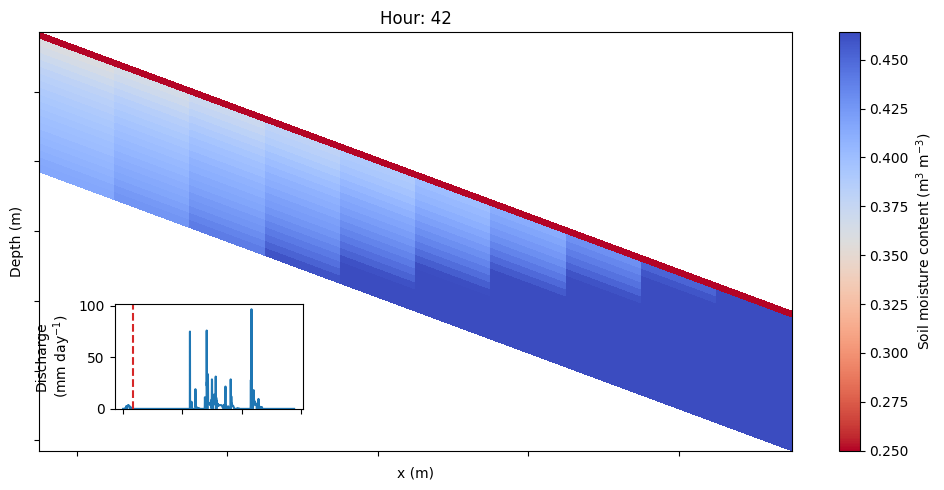

In [29]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

frames = []

inset_location = [0.1, 0.1, 0.25, 0.25],
#for t in range(len(smc_df)):
for t in range(0, len(smc_df) + 1, 12):
    fig, ax = plt.subplots(figsize=(10, 5), sharex=True)
    c = ax.pcolor(
        x, y, smc_df.iloc[t].values.reshape((number_of_columns, number_of_layers)).T,
        vmin=0.25,
        vmax=0.464,
        cmap='coolwarm_r'
    )
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_ylabel('Depth (m)')
    fig.colorbar(c, ax=ax, label='Soil moisture content (m$^3$ m$^{-3}$)')
    ax.set_xlabel('x (m)')
    ax.set_title(f'Hour: {int(t / 2)}')


    inset_ax = ax.inset_axes(
        inset_location[0],
    )
    inset_ax.plot(
        channel_df.values[:, 1],
    )

    y_max = inset_ax.get_ylim()[1]

    inset_ax.plot([t, t], [0, y_max], '--', color='tab:red')

    inset_ax.set_xticklabels([])
    inset_ax.set_ylabel('Discharge\n(mm day$^{-1}$)')
    inset_ax.set_ylim([0, y_max])

    fig.tight_layout()
    fname = f'tmp/smc_{t:04d}.png'
    fig.savefig(fname, dpi=300)
    plt.close()

    frames.append(imageio.v2.imread(fname))

imageio.mimsave(f'smc.gif', frames, duration=30 / len(frames) * 1000)
!rm tmp/smc_*.png

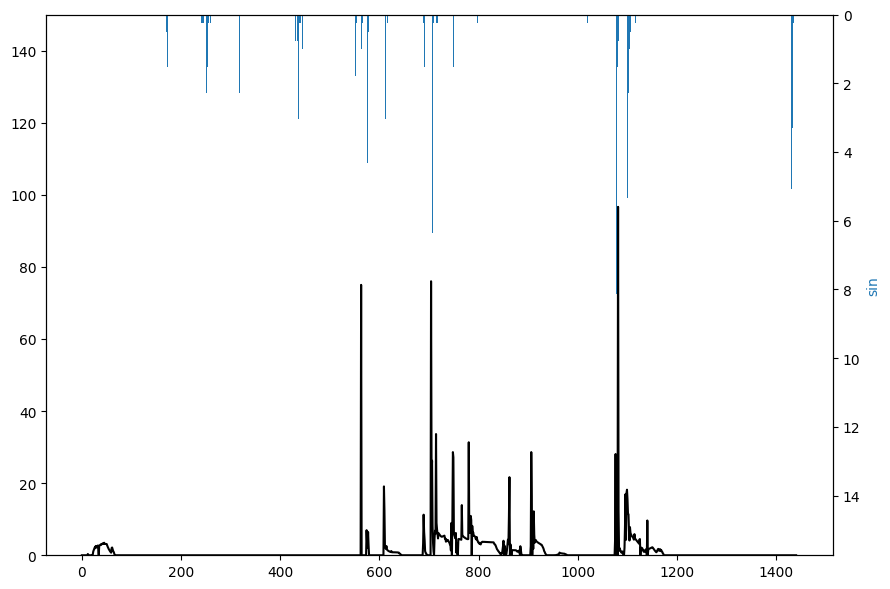

In [32]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(channel_df.values[:, 1], color='k')
ax.set_ylim([0, 150])
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
ax2.bar(hydro_df.index, hydro_df['PRCP'], color=color)
ax2.invert_yaxis()  # reverse the y-axis
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


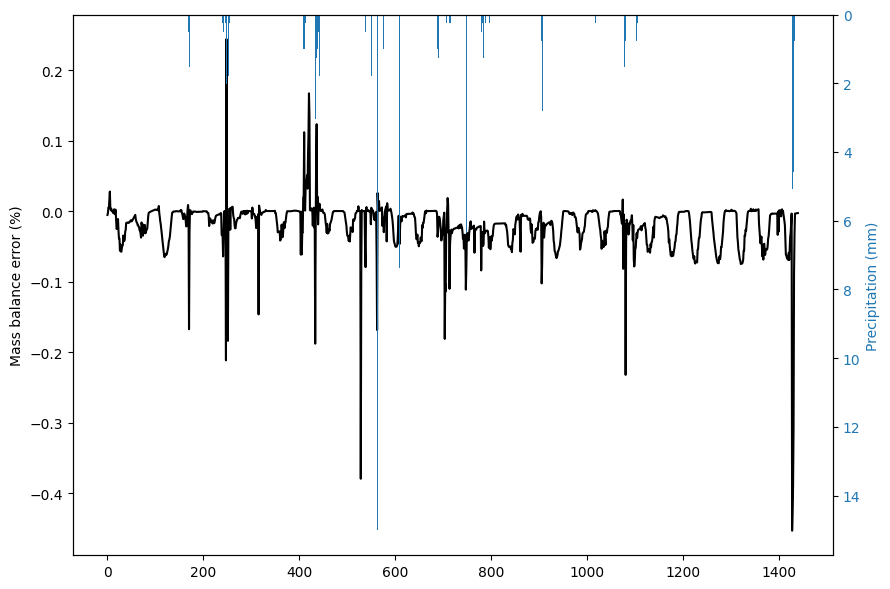

In [42]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(mb_df.values, color='k')
ax.set_ylabel('Mass balance error (%)')
#ax.set_ylim([0, 150])
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Precipitation (mm)', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)
ax2.bar(hydro_df.index, hydro_df['PRCP'], color=color)
ax2.invert_yaxis()  # reverse the y-axis
fig.tight_layout()  # otherwise the right y-label is slightly clipped